# Implementation and run with U-Net architecture

In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
import os
import matplotlib.image as mpimg
import cv2

In [3]:
import unet

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def rotate_img(img, angle, rgb):
    rows, cols = img.shape[0:2]
    if rgb:
        id = 1
    else:
        id = 0
    rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, id)
    return cv2.warpAffine(img, rot_M, (cols, rows))

In [6]:
def flip_img(img, border_id):
    return cv2.flip(img, border_id)

In [7]:
def extract_data(filename, num_images, mytype='train'):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting data...')
    imgs = []
    for i in range(1, num_images+1):
        if i%10==0:
            print('Extract original images... i=',i)
        if mytype == 'train':
            imageid = "satImage_%.3d" % i
        else:
            imageid = "test_%.1d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
            
            img_cv2 = cv2.imread(image_filename)
            img_flip = np.flip(flip_img(img_cv2, 1),2)/255
            imgs.append(img_flip)
            
            imgs.append(np.flip(rotate_img(img_cv2, 90, True),2)/255)
            imgs.append(np.flip(rotate_img(img_cv2, 180, True),2)/255)
            imgs.append(np.flip(rotate_img(img_cv2, 270, True),2)/255)
            
            if i==2:
                plt.subplot(151),plt.imshow(img),plt.title('Input')
                plt.subplot(152),plt.imshow(np.flip(rotate_img(img_cv2, 90, True),2)/255),plt.title('Output')
                plt.subplot(153),plt.imshow(np.flip(rotate_img(img_cv2, 180, True),2)/255),plt.title('Output')
                plt.subplot(154),plt.imshow(np.flip(rotate_img(img_cv2, 270, True),2)/255),plt.title('Output')
                plt.subplot(155),plt.imshow(img_flip),plt.title('Output')
                plt.show()
            
        else:
            print ('File ' + image_filename + ' does not exist')
    
    img_size = imgs[0].shape[0]
    img_height = imgs[0].shape[1]
    if img_size != img_height:
        print('Error!! The images should have their height equal to their width.')

    return np.asarray(imgs).astype(np.float32)

In [8]:
# Assign a label to a patch v
def value_to_class(v):
    # you can remark the hot encoding
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    df = np.sum(v)
    if df > foreground_threshold:
        return [0, 1]
    else:
        return [1, 0]

In [9]:
# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    print('Extracting labels...')
    gt_imgs = []
    for i in range(1, num_images+1):
        if i%10==0:
            print('Extract groundtruth images... i=',i)
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
            
            img_cv2 = cv2.imread(image_filename,0)
            gt_img_flip = flip_img(img_cv2, 1)/255
            gt_imgs.append(gt_img_flip)
            
            gt_imgs.append(rotate_img(img_cv2, 90, True)/255)
            gt_imgs.append(rotate_img(img_cv2, 180, True)/255)
            gt_imgs.append(rotate_img(img_cv2, 270, True)/255)
            
            if i==2:
                plt.subplot(151),plt.imshow(img),plt.title('Input')
                plt.subplot(152),plt.imshow(rotate_img(img_cv2, 90, True)/255),plt.title('Output')
                plt.subplot(153),plt.imshow(rotate_img(img_cv2, 180, True)/255),plt.title('Output')
                plt.subplot(154),plt.imshow(rotate_img(img_cv2, 270, True)/255),plt.title('Output')
                plt.subplot(155),plt.imshow(gt_img_flip),plt.title('Output')
                plt.show()
            
        else:
            print ('File ' + image_filename + ' does not exist')

    data = np.asarray(gt_imgs)
    out_lab = [[[value_to_class(data[i][j][k]) \
                 for k in range(data.shape[2])] \
                for j in range(data.shape[1])] \
               for i in range(data.shape[0])]

    # Convert to dense 1-hot representation.
    return np.asarray(out_lab).astype(np.float32)

Extracting data...


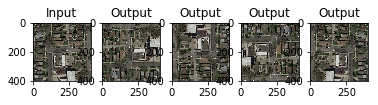

Extract original images... i= 10
Extract original images... i= 20
Extract original images... i= 30
Extract original images... i= 40
Extract original images... i= 50
Extracting labels...


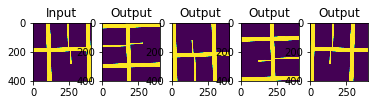

Extract groundtruth images... i= 10
Extract groundtruth images... i= 20
Extract groundtruth images... i= 30
Extract groundtruth images... i= 40
Extract groundtruth images... i= 50


In [10]:
########### define directory of the training images ############################
data_dir = '../training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/'
TRAINING_SIZE = 50

data = extract_data(train_data_filename, TRAINING_SIZE)
labels = extract_labels(train_labels_filename, TRAINING_SIZE)

In [32]:
initial_data = data[range(0,data.shape[0],5)]
initial_labels = labels[range(0,data.shape[0],5)]

In [11]:
print(data.shape)
print(labels.shape)

(250, 400, 400, 3)
(250, 400, 400, 2)


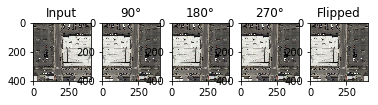

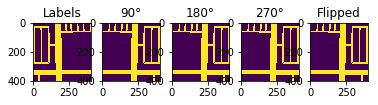

In [12]:
index = 30
plt.subplot(151),plt.imshow(data[5*index]),plt.title('Input')
plt.subplot(152),plt.imshow(data[5*index+1]),plt.title('90°')
plt.subplot(153),plt.imshow(data[5*index+1]),plt.title('180°')
plt.subplot(154),plt.imshow(data[5*index+1]),plt.title('270°')
plt.subplot(155),plt.imshow(data[5*index+1]),plt.title('Flipped')
plt.show()

plt.subplot(151),plt.imshow(labels[5*index,:,:,1]),plt.title('Labels')
plt.subplot(152),plt.imshow(labels[5*index+1,:,:,1]),plt.title('90°')
plt.subplot(153),plt.imshow(labels[5*index+1,:,:,1]),plt.title('180°')
plt.subplot(154),plt.imshow(labels[5*index+1,:,:,1]),plt.title('270°')
plt.subplot(155),plt.imshow(labels[5*index+1,:,:,1]),plt.title('Flipped')
plt.show()

In [16]:
net = unet.Unet(channels=3, n_class=2, layers=5, features_root=4) 
    #, cost_kwargs={'regularizer':1e-4}) # class_weights

2017-12-13 11:13:45,030 Layers 5, features 4, filter size 3x3, pool size: 2x2


In [17]:
# Optimizer = "momentum" or "adam"
trainer = unet.Trainer(net, batch_size=20, optimizer="adam") 
    #, opt_kwargs=dict(momentum=0.2)), learning_rate, decay_rate

In [18]:
path = trainer.train(data=data, labels=labels, output_path="./unet_trained", training_iters=20, \
                     epochs=20, dropout=1.0, display_step=5, prediction_path='prediction')

2017-12-13 11:13:48,167 Removing '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/tf_unet/demo/prediction'
2017-12-13 11:13:48,168 Removing '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/tf_unet/demo/unet_trained'
2017-12-13 11:13:48,168 Allocating '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/tf_unet/demo/prediction'
2017-12-13 11:13:48,169 Allocating '/home/ondine/Documents/Cours/LMO_ML/project2/project_Ondine/tf_unet/demo/unet_trained'
2017-12-13 11:14:07,888 Verification error= 40.3%, loss= 0.6971
2017-12-13 11:14:10,057 Start optimization
2017-12-13 11:14:14,636 Iter 0, Minibatch Loss= 0.6892, Training Accuracy= 0.6927, Minibatch error= 30.7%
2017-12-13 11:14:32,490 Iter 5, Minibatch Loss= 0.6765, Training Accuracy= 0.7962, Minibatch error= 20.4%
2017-12-13 11:14:50,079 Iter 10, Minibatch Loss= 0.6662, Training Accuracy= 0.7631, Minibatch error= 23.7%
2017-12-13 11:15:07,627 Iter 15, Minibatch Loss= 0.6496, Training Accuracy= 0.7925, Miniba

2017-12-13 11:36:09,415 Iter 270, Minibatch Loss= 0.3861, Training Accuracy= 0.8037, Minibatch error= 19.6%
2017-12-13 11:36:29,036 Iter 275, Minibatch Loss= 0.4152, Training Accuracy= 0.8051, Minibatch error= 19.5%
2017-12-13 11:36:44,137 Epoch 13, Average loss: 0.3862, learning rate: 0.0010
2017-12-13 11:37:06,984 Verification error= 19.2%, loss= 0.3738
2017-12-13 11:37:14,139 Iter 280, Minibatch Loss= 0.3315, Training Accuracy= 0.8420, Minibatch error= 15.8%
2017-12-13 11:37:33,423 Iter 285, Minibatch Loss= 0.3367, Training Accuracy= 0.8291, Minibatch error= 17.1%
2017-12-13 11:37:52,545 Iter 290, Minibatch Loss= 0.4051, Training Accuracy= 0.7952, Minibatch error= 20.5%
2017-12-13 11:38:11,296 Iter 295, Minibatch Loss= 0.3692, Training Accuracy= 0.8097, Minibatch error= 19.0%
2017-12-13 11:38:25,256 Epoch 14, Average loss: 0.3673, learning rate: 0.0010
2017-12-13 11:38:46,513 Verification error= 19.2%, loss= 0.3563
2017-12-13 11:38:53,593 Iter 300, Minibatch Loss= 0.3054, Training A

In [34]:
prediction = net.predict(path, initial_data)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.cpkt


2017-12-13 11:56:18,928 Restoring parameters from ./unet_trained/model.cpkt
2017-12-13 11:56:19,348 Model restored from file: ./unet_trained/model.cpkt


/home/ondine/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


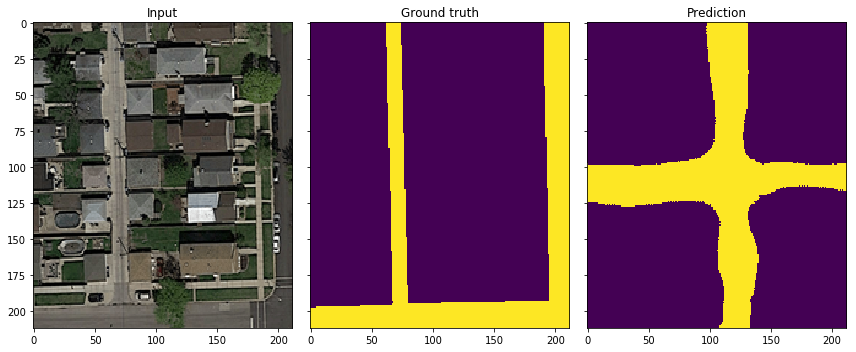

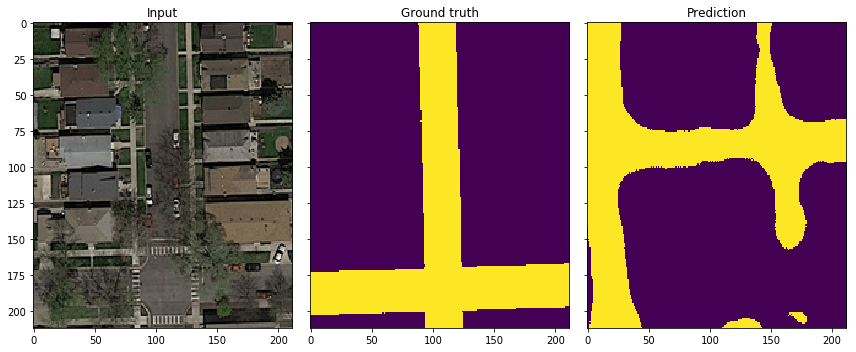

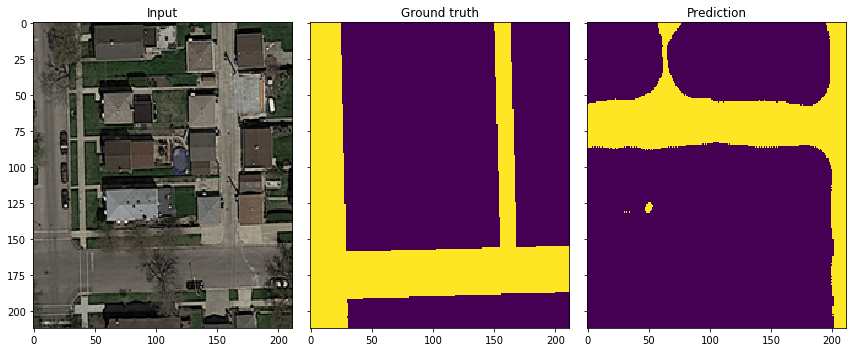

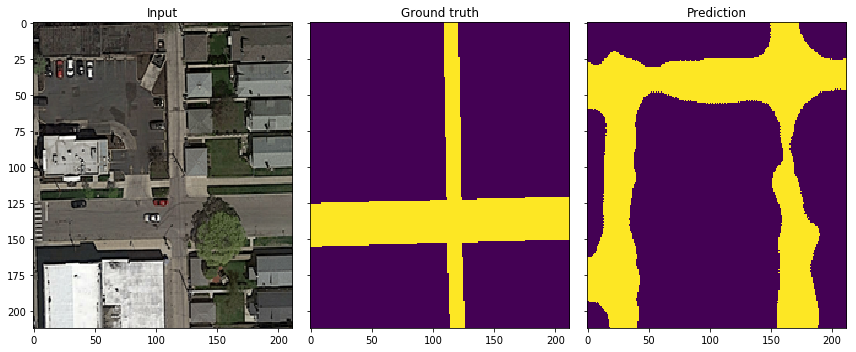

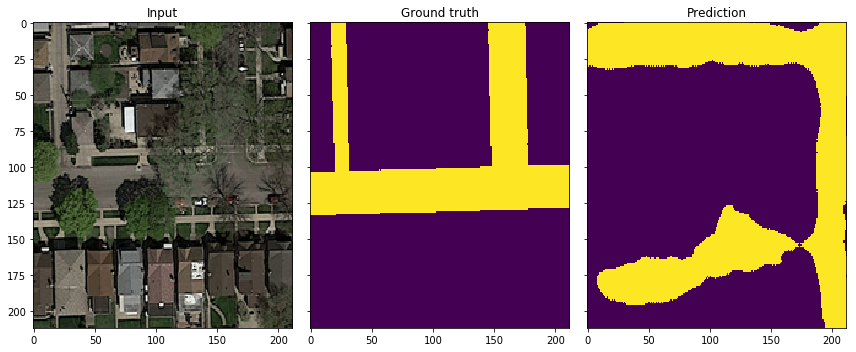

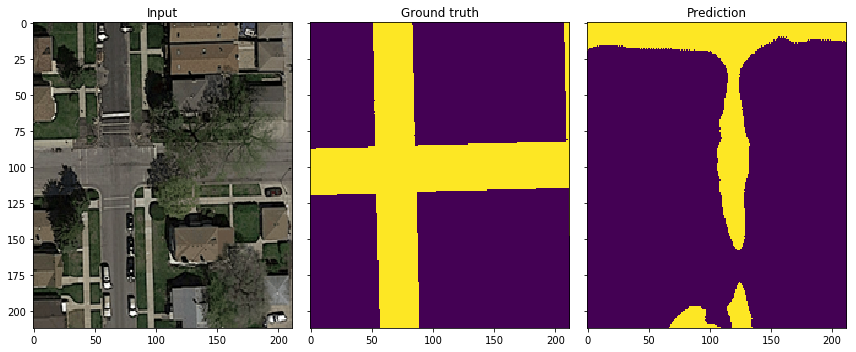

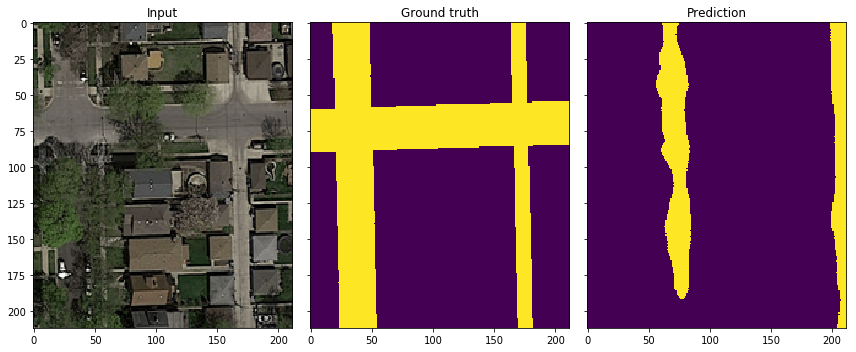

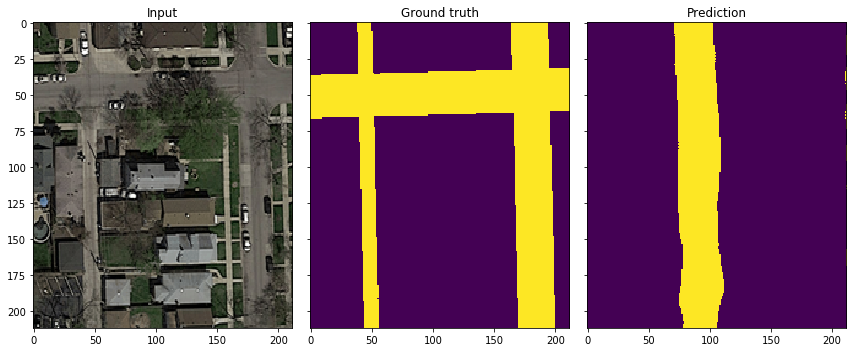

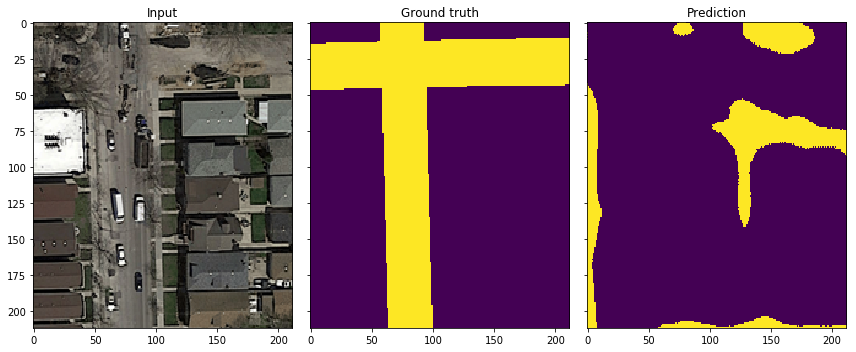

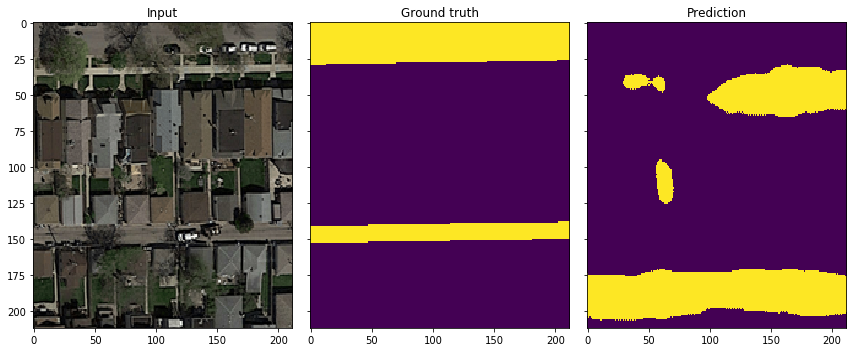

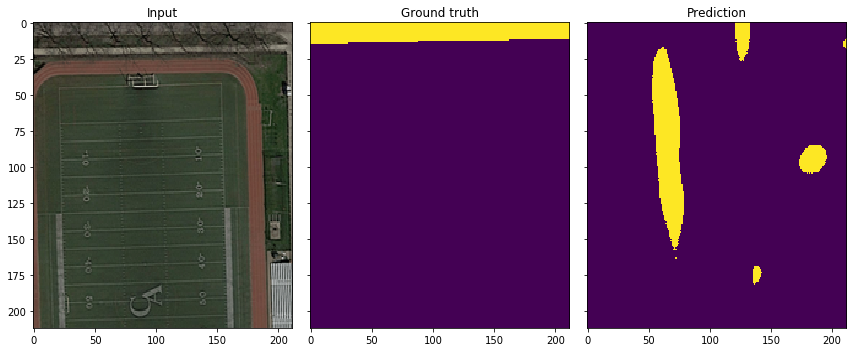

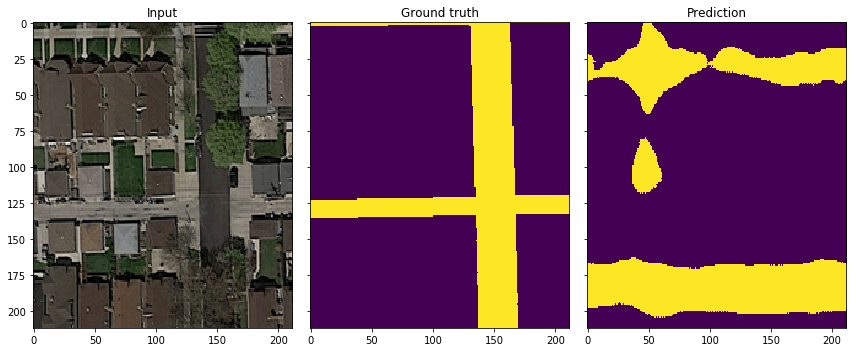

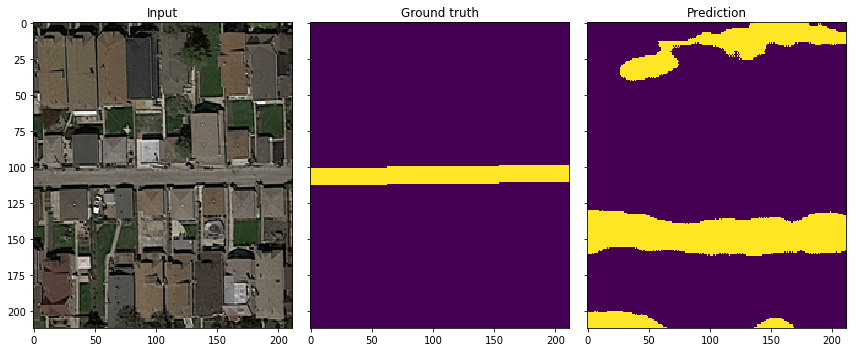

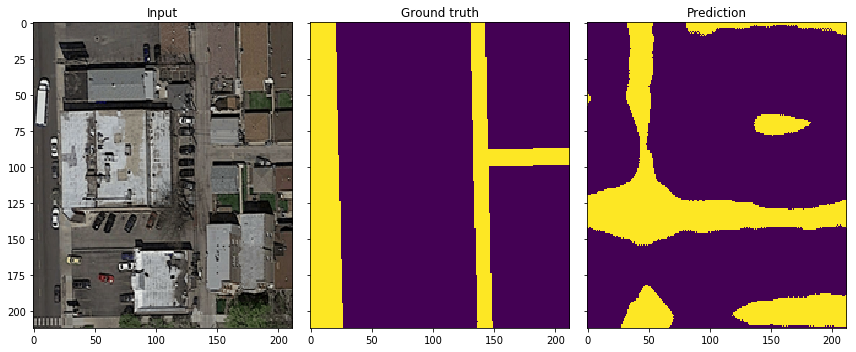

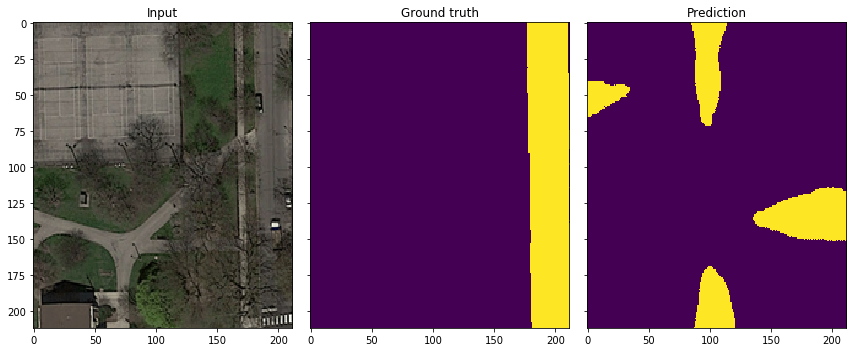

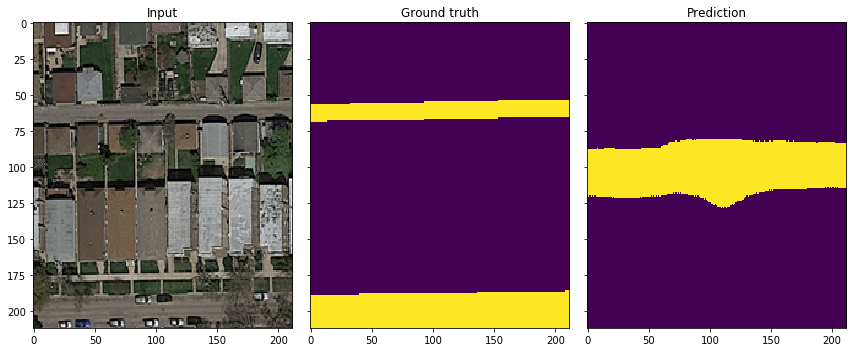

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


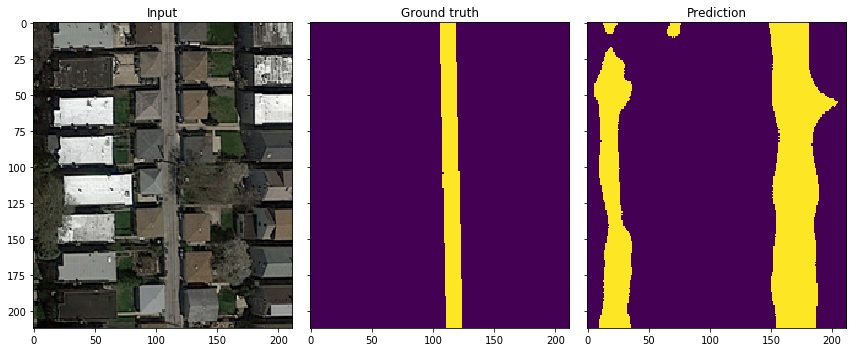

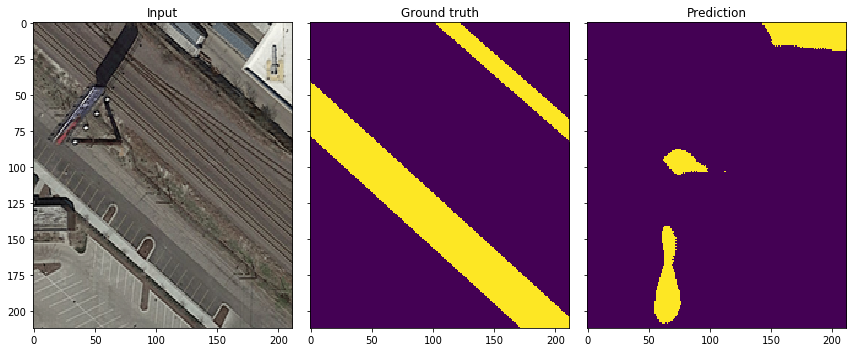

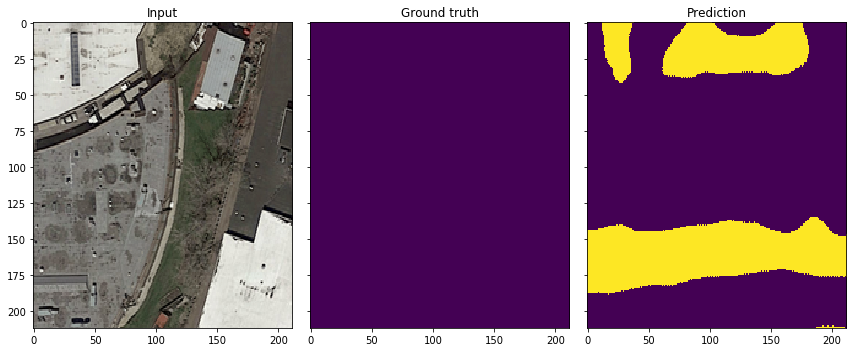

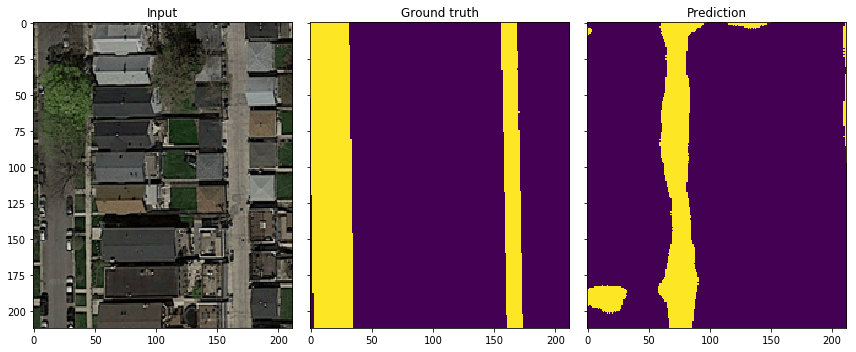

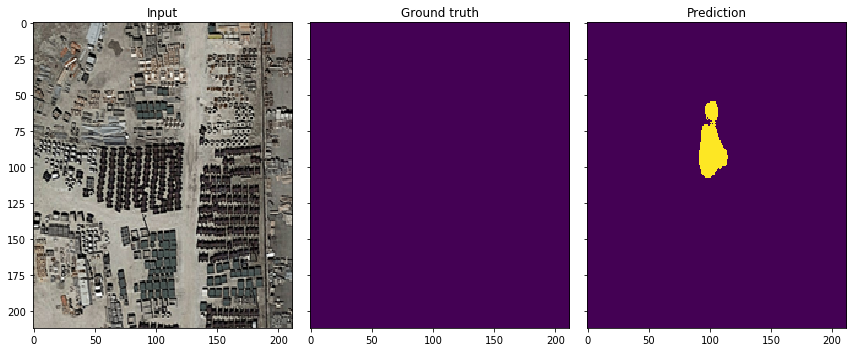

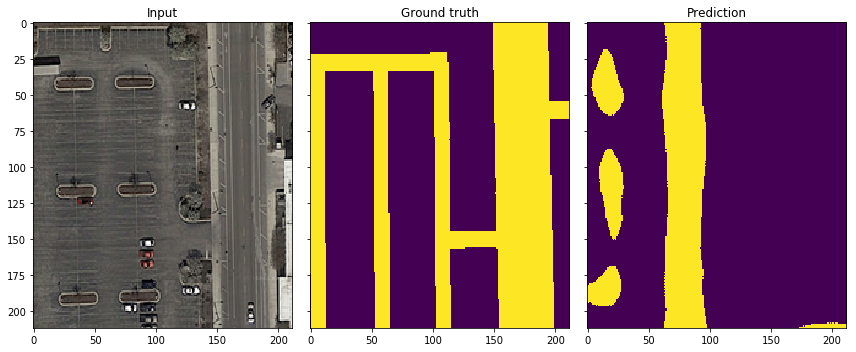

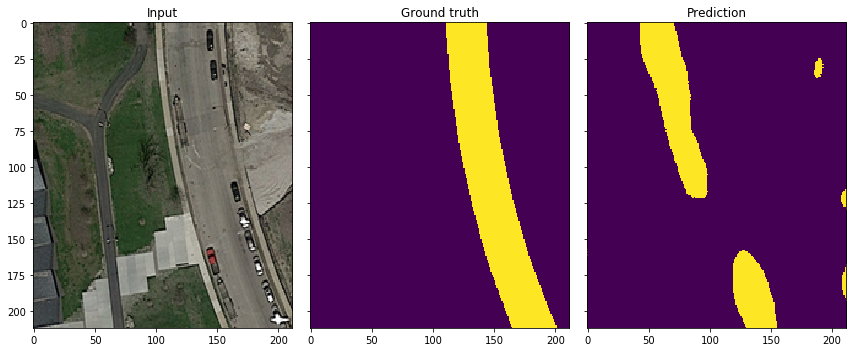

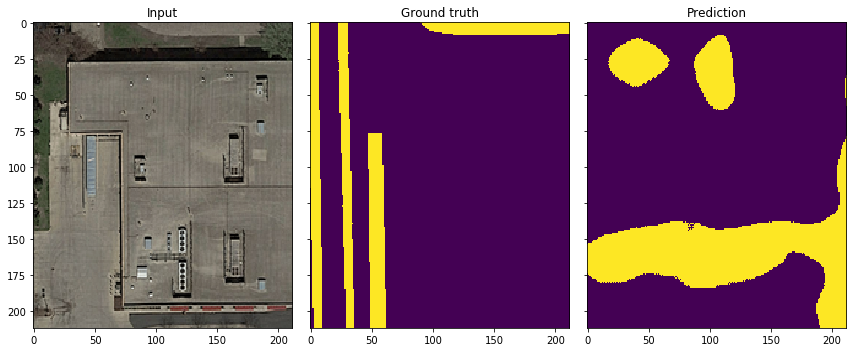

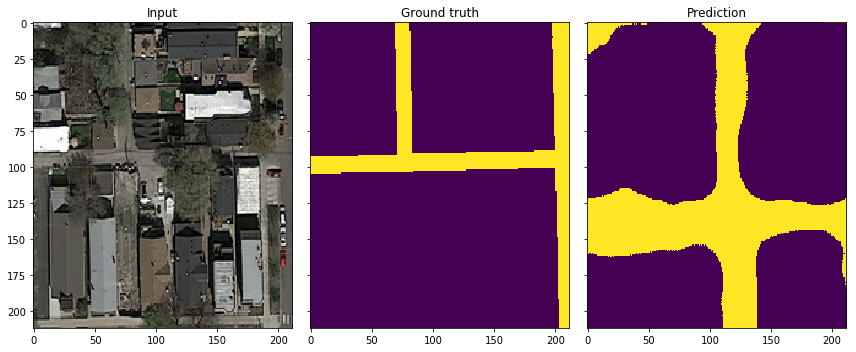

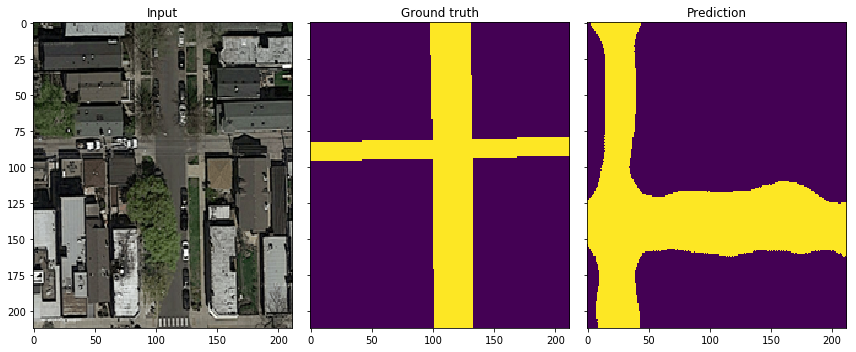

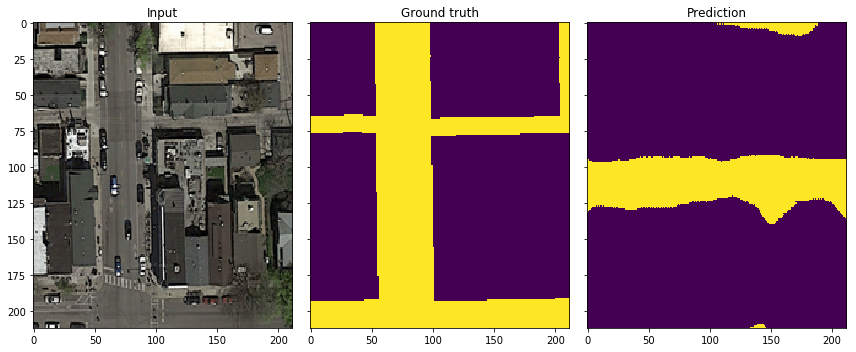

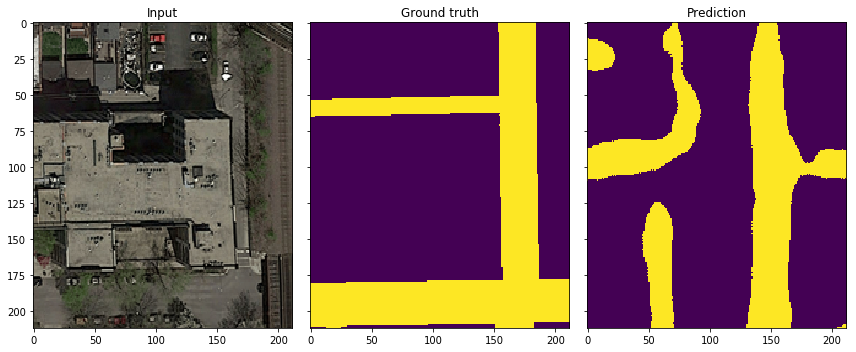

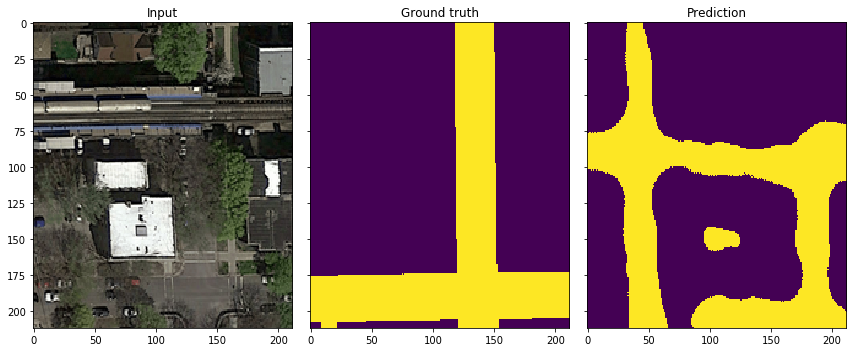

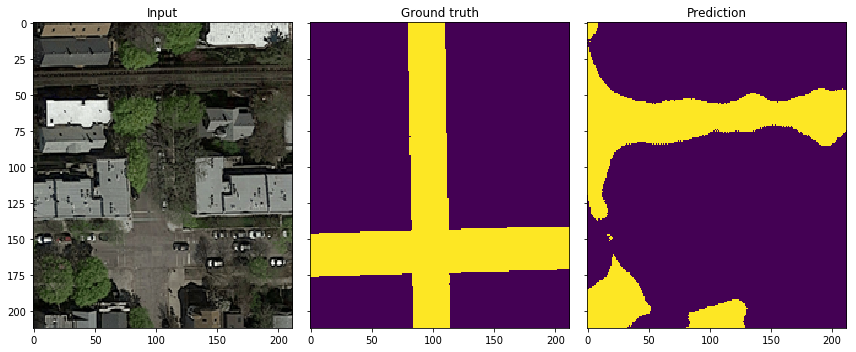

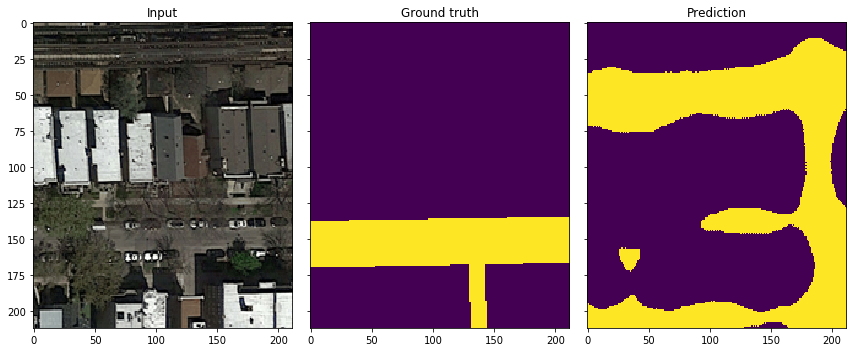

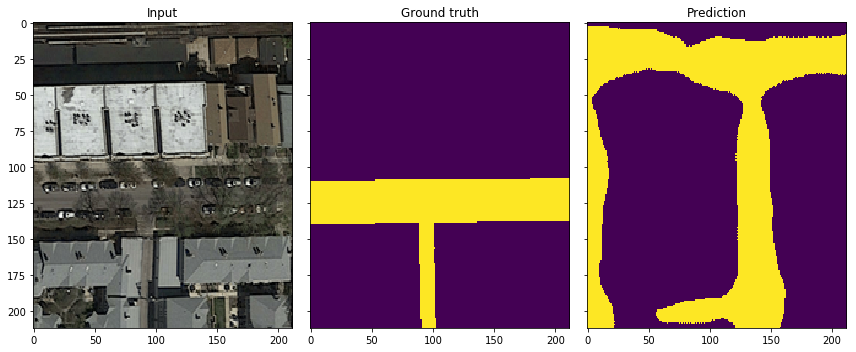

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [41]:
id_end = 50
for num in range(0,id_end):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
    ax[0].imshow(initial_data[num], aspect="auto")
    ax[1].imshow(initial_labels[num,:,:,1], aspect="auto")
    mask = prediction[num,:,:,1] > 0.5
    ax[2].imshow(mask, aspect="auto")
    #ax[2].imshow(prediction[num,:,:,1], aspect="auto")
    ax[0].set_title("Input")
    ax[1].set_title("Ground truth")
    ax[2].set_title("Prediction")
    fig.tight_layout()
    fig.savefig("output/roadSegmentation.png")